In [1]:
import sys
sys.path.append('C:\\Users\\Yonatan Gideoni\\Desktop\\ML4Q\\c3')

### Entangling gate on two coupled qubits

#### Imports

In [2]:
# System imports
import copy
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from typing import List
from pprint import pprint

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils

# Qiskit related modules
from c3.qiskit import C3Provider
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram

#### Model components
The model consists of two qubits with 3 levels each and slightly different parameters:

In [3]:
qubit_lvls = 5
freq_q1 = 5e9
anhar_q1 = -210e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(value=freq_q1, min_val=4.995e9, max_val=5.005e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q1, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q1, min_val=1e-6, max_val=90e-6, unit='s'),
    t2star=Qty(value=t2star_q1, min_val=10e-6, max_val=90e-3, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

freq_q2 = 5.6e9
anhar_q2 = -240e6
t1_q2 = 23e-6
t2star_q2 = 31e-6
q2 = chip.Qubit(
    name="Q2",
    desc="Qubit 2",
    freq=Qty(value=freq_q2, min_val=5.595e9, max_val=5.605e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q2, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q2, min_val=1e-6, max_val=90e-6, unit='s'),
    t2star=Qty(value=t2star_q2, min_val=10e-6, max_val=90e-6, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

There is a static coupling in x-direction between them: $(b_1+b_1^\dagger)(b_2+b_2^\dagger)$

In [4]:
coupling_strength = 50e6
q1q2 = chip.Coupling(
    name="Q1-Q2",
    desc="coupling",
    comment="Coupling qubit 1 to qubit 2",
    connected=["Q1", "Q2"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3,
        max_val=200e6,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

and each qubit has a drive line

In [5]:
drive1 = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)
drive2 = chip.Drive(
    name="d2",
    desc="Drive 2",
    comment="Drive line 2 on qubit 2",
    connected=["Q2"],
    hamiltonian_func=hamiltonians.x_drive
)

All parts are collected in the model.

In [6]:
model = Mdl(
    [q1, q2],  # Individual, self-contained components
    [drive1, drive2, q1q2],  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(True)

#### Control signals
The devices for the control line are set up

In [7]:
sim_res = 100e9  # Resolution for numerical simulation
awg_res = 2e9  # Realistic, limited resolution of an AWG
v2hz = 1e9

lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')
dig_to_an = devices.DigitalToAnalog(name="dac", resolution=sim_res)
v_to_hz = devices.VoltsToHertz(
    name='v_to_hz',
    V_to_Hz=Qty(value=v2hz, min_val=0.9e9, max_val=1.1e9, unit='Hz/V')
)

The generator combines the parts of the signal generation and assignes a signal chain to each control line.

In [8]:
generator = Gnr(
    devices={
        "LO": lo,
        "AWG": awg,
        "DigitalToAnalog": dig_to_an,
        "Mixer": mixer,
        "VoltsToHertz": v_to_hz
    },
    chains={
        "d1": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Mixer": ["LO", "DigitalToAnalog"],
            "VoltsToHertz": ["Mixer"],
        },
        "d2": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Mixer": ["LO", "DigitalToAnalog"],
            "VoltsToHertz": ["Mixer"],
        }
    }
)

#### Gates-set and Parameter map
Following a general cross resonance scheme, both qubits will be resonantly driven at the frequency of qubit 2 with a Gaussian envelope. We drive qubit 1 (the control) at the frequency of qubit 2 (the target) with a higher amplitude to compensate for the reduced Rabi frequency.

In [9]:
t_final = 45e-9
sideband = 50e6

In [10]:
def_params = {
    'amp': Qty(
        value=1.,
        min_val=0.0,
        max_val=100.,
        unit="V"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    't_final': Qty(
        value=t_final,
        min_val=-0.5 * t_final,
        max_val=2. * t_final,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6,
        min_val=-56 * 1e6,
        max_val=-52 * 1e6,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}

def_env = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=def_params,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

In [11]:
n_gaussians_per_q = 10
sig_envelopes = {'d1': [], 'd2': []}

sigma = t_final / (3 * n_gaussians_per_q)
times = np.linspace(2*sigma, 2*(t_final - sigma), n_gaussians_per_q)
sigma = Qty(value=sigma, min_val=0.5 * sigma, max_val=2 * sigma, unit="s")
default_amp = 1e-5 # arbitrary almost-zero number
for i, t in enumerate(times):
    d1_gauss = copy.deepcopy(def_env)
    d1_gauss.name += str(i)
    d1_gauss.params['t_final'].set_value(t)
    d1_gauss.params['amp'].set_value(default_amp)
    d1_gauss.params['xy_angle'].set_value(default_amp)
    d1_gauss.params['sigma'] = sigma

    d2_gauss = copy.deepcopy(d1_gauss)

    sig_envelopes['d1'].append(d1_gauss)
    sig_envelopes['d2'].append(d2_gauss)

The carrier signal of each drive for the 2 Qubit gates is set to the resonance frequency of the target qubit.

In [12]:
lo_freq_q1 = freq_q1 + sideband
lo_freq_q2 = freq_q2 + sideband

carr_2Q_1 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 1",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

carr_2Q_2 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 2",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

#### Instructions
The instruction to be optimised is a CNOT gates controlled by qubit 1.

In [13]:
# CNOT controlled by qubit 1
cnot12 = gates.Instruction(
    name="cnot", targets=[0, 1], t_start=0.0, t_end=t_final, channels=["d1", "d2"],
    ideal=np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ])
)

C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\signal\gates.py:135: UserWarning: No ideal gate found for gate: cnot. Use set_ideal() explicitly.
  warnings.warn(


In [14]:
# CZ controlled by qubit 1
cz = gates.Instruction(
    name="cz", targets=[0, 1], t_start=0.0, t_end=t_final, channels=["d1", "d2"],
    ideal=np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, -1]
    ])
)

In [15]:
gate = cnot12
gate_name = gate.get_key()

In [16]:
gate.add_component(carr_2Q_1, "d1")
gate.add_component(carr_2Q_2, "d2")
gate.comps["d1"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final) * 2 * np.pi % (2 * np.pi)
)

for drive_line, envs in sig_envelopes.items():
    for env in envs:
        gate.add_component(env, drive_line)

#### The experiment
All components are collected in the parameter map and the experiment is set up.

In [17]:
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map)

#### Dynamics

The system is initialised in the state $|0,1\rangle$ so that a transition to $|1,1\rangle$ should be visible.

In [18]:
psi_init = [[0] * qubit_lvls ** 2]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

In [19]:
def plot_dynamics(exp, psi_init, seq, disp_legend: bool=False):
    """
    Plotting code for time-resolved populations.

    Parameters
    ----------
    psi_init: tf.Tensor
        Initial state or density matrix.
    seq: list
        List of operations to apply to the initial state.
    """
    model = exp.pmap.model
    exp.compute_propagators()
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in seq:
        for du in dUs[gate]:
            psi_t = np.matmul(du.numpy(), psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)

    fig, axs = plt.subplots(1, 1)
    ts = exp.ts
    dt = ts[1] - ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])
    axs.plot(ts / 1e-9, pop_t.T)
    axs.grid(linestyle="--")
    axs.tick_params(
        direction="in", left=True, right=True, top=True, bottom=True
    )
    axs.set_xlabel('Time [ns]')
    axs.set_ylabel('Population')
    if disp_legend:
        plt.legend(model.state_labels, loc='center right')


def plot_signal(drivers_signals: dict, t_final: float, 
                n_points: int= 1000, disp_legend: bool=False):
    signal_t = np.linspace(0, t_final, n_points)
    
    n_drivers = len(drivers_signals)
    res_signal = np.zeros((n_drivers, len(signal_t)), dtype=np.complex128)
    fig, axs = plt.subplots(1, n_drivers, sharey="all")

    for driver, envs in drivers_signals.items():
        driver_ind = int(driver[1:])-1
        for env in envs:
            # de-normalize the amplitude so it has units of volts
            ts = awg.create_ts(0, t_final)
            env.normalize_pulse = False
            area = abs(env.get_shape_values(ts).numpy()).sum()
            amplitude = env.params['amp'].numpy()
            real_amplitude = amplitude / area

            signal = env.get_shape_values(signal_t).numpy() * real_amplitude
            res_signal[driver_ind] += signal

            env.normalize_pulse = True

            axs[driver_ind].plot(signal_t*1e9, np.real(signal), label=env.name)
    
    for driver in range(n_drivers):
        ax = axs[driver]
        
        ax.plot(signal_t*1e9, np.real(res_signal[driver]), 
                           label='Resulting signal', c='k', linewidth=2, linestyle='dashed')
        
        ax.set_title(f'Driver {driver+1}')
        ax.grid()
        ax.set_xlabel('Time[ns]')
        ax.set_ylabel('Signal[V]')
        ax.set_xlim(0, t_final*1e9)
        if disp_legend:
            ax.legend()
    
    plt.suptitle('Real part of pulses')


def getQubitsPopulation(population: np.array, dims: List[int]) -> np.array:
    """
    Splits the population of all levels of a system into the populations of levels per subsystem.
    Parameters
    ----------
    population: np.array
        The time dependent population of each energy level. First dimension: level index, second dimension: time.
    dims: List[int]
        The number of levels for each subsystem.
    Returns
    -------
    np.array
        The time-dependent population of energy levels for each subsystem. First dimension: subsystem index, second
        dimension: level index, third dimension: time.
    """
    numQubits = len(dims)

    # create a list of all levels
    qubit_levels = []
    for dim in dims:
        qubit_levels.append(list(range(dim)))
    combined_levels = list(itertools.product(*qubit_levels))

    # calculate populations
    qubitsPopulations = np.zeros((numQubits, dims[0], population.shape[1]))
    for idx, levels in enumerate(combined_levels):
        for i in range(numQubits):
            qubitsPopulations[i, levels[i]] += population[idx]
    return qubitsPopulations


def plotSplittedPopulation(
        exp: Exp,
        psi_init: tf.Tensor,
        sequence: List[str]
) -> None:
    """
    Plots time dependent populations for multiple qubits in separate plots.
    Parameters
    ----------
    exp: Experiment
        The experiment containing the model and propagators
    psi_init: np.array
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state
    -------
    """
    # calculate the time dependent level population
    model = exp.pmap.model
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in sequence:
        for du in dUs[gate]:
            psi_t = np.matmul(du, psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)
    dims = [s.hilbert_dim for s in model.subsystems.values()]
    splitted = getQubitsPopulation(pop_t, dims)

    # timestamps
    dt = exp.ts[1] - exp.ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])

    # create both subplots
    titles = list(exp.pmap.model.subsystems.keys())
    fig, axs = plt.subplots(1, len(splitted), sharey="all")
    for idx, ax in enumerate(axs):
        ax.plot(ts / 1e-9, splitted[idx].T)
        ax.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Population")
        ax.set_title(titles[idx])
        ax.legend([str(x) for x in np.arange(dims[idx])])
        ax.grid()

    plt.tight_layout()
    plt.show()

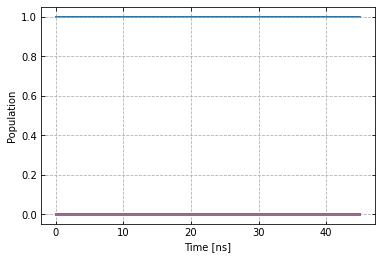

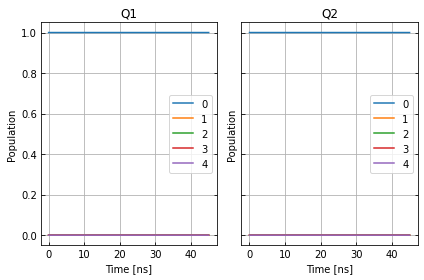

In [20]:
sequence = [gate_name]
plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

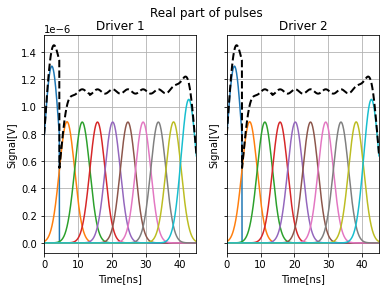

In [21]:
plot_signal(sig_envelopes, t_final)

#### Open-loop optimal control

In [22]:
opt_gates = [gate_name]
exp.set_opt_gates(opt_gates)

gateset_opt_map = [
    [(gate_name, "d1", "carrier", "framechange")],
    [(gate_name, "d2", "carrier", "framechange")],
]

opt_params = {'amp', 'xy_angle', 'freq_offset', 'sigma'}
for drive_line, envs in sig_envelopes.items():
    for env in envs:
        for opt_param in opt_params:
            gateset_opt_map.append([(gate_name, drive_line, env.name, opt_param)])

parameter_map.set_opt_map(gateset_opt_map)

In [23]:
gateset_opt_map

[['cnot[0, 1]-d1-carrier-framechange'],
 ['cnot[0, 1]-d2-carrier-framechange'],
 ['cnot[0, 1]-d1-gauss0-freq_offset'],
 ['cnot[0, 1]-d1-gauss0-sigma'],
 ['cnot[0, 1]-d1-gauss0-amp'],
 ['cnot[0, 1]-d1-gauss0-xy_angle'],
 ['cnot[0, 1]-d1-gauss1-freq_offset'],
 ['cnot[0, 1]-d1-gauss1-sigma'],
 ['cnot[0, 1]-d1-gauss1-amp'],
 ['cnot[0, 1]-d1-gauss1-xy_angle'],
 ['cnot[0, 1]-d1-gauss2-freq_offset'],
 ['cnot[0, 1]-d1-gauss2-sigma'],
 ['cnot[0, 1]-d1-gauss2-amp'],
 ['cnot[0, 1]-d1-gauss2-xy_angle'],
 ['cnot[0, 1]-d1-gauss3-freq_offset'],
 ['cnot[0, 1]-d1-gauss3-sigma'],
 ['cnot[0, 1]-d1-gauss3-amp'],
 ['cnot[0, 1]-d1-gauss3-xy_angle'],
 ['cnot[0, 1]-d1-gauss4-freq_offset'],
 ['cnot[0, 1]-d1-gauss4-sigma'],
 ['cnot[0, 1]-d1-gauss4-amp'],
 ['cnot[0, 1]-d1-gauss4-xy_angle'],
 ['cnot[0, 1]-d1-gauss5-freq_offset'],
 ['cnot[0, 1]-d1-gauss5-sigma'],
 ['cnot[0, 1]-d1-gauss5-amp'],
 ['cnot[0, 1]-d1-gauss5-xy_angle'],
 ['cnot[0, 1]-d1-gauss6-freq_offset'],
 ['cnot[0, 1]-d1-gauss6-sigma'],
 ['cnot[0, 1]-

As a fidelity function we choose unitary fidelity as well as LBFG-S (a wrapper of the scipy implementation) from our library.

In [24]:
import os
import tempfile
from c3.optimizers.optimalcontrol import OptimalControl

log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")
opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=["Q1", "Q2"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={
        "maxiter": 200,
    },
)

In [25]:
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)
res = opt.optimize_controls();

C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\utils\utils.py:64: UserWarning: OSError encountered while creating symlink
  warnings.warn("OSError encountered while creating symlink")


C3:STATUS:Saving as: C:\Users\YONATA~1\AppData\Local\Temp\tmps47ox0tn\c3logs\c1_unitary_infid_set_lbfgs\2022_08_26_T_17_16_02\open_loop.c3log


C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: cnot[0, 1]-d1-gauss0-sigma has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: cnot[0, 1]-d1-gauss1-sigma has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: cnot[0, 1]-d1-gauss2-sigma has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: cnot[0, 1]-d1-gauss3-sigma has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: cnot[0, 1]-d1-gauss4-sigma has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gid

The final parameters and the fidelity are

In [26]:
parameter_map.print_parameters()
print(1-opt.current_best_goal)

cnot[0, 1]-d1-carrier-framechange     : 1.570 rad 
cnot[0, 1]-d2-carrier-framechange     : 2.393 rad 
cnot[0, 1]-d1-gauss0-freq_offset      : -53.000 MHz 2pi 
cnot[0, 1]-d1-gauss0-sigma            : 2.243 ns 
cnot[0, 1]-d1-gauss0-amp              : 30.483 mV 
cnot[0, 1]-d1-gauss0-xy_angle         : -112.289 mrad 
cnot[0, 1]-d1-gauss1-freq_offset      : -53.001 MHz 2pi 
cnot[0, 1]-d1-gauss1-sigma            : 2.243 ns 
cnot[0, 1]-d1-gauss1-amp              : 3.545 V 
cnot[0, 1]-d1-gauss1-xy_angle         : 60.803 mrad 
cnot[0, 1]-d1-gauss2-freq_offset      : -53.004 MHz 2pi 
cnot[0, 1]-d1-gauss2-sigma            : 2.243 ns 
cnot[0, 1]-d1-gauss2-amp              : 15.478 V 
cnot[0, 1]-d1-gauss2-xy_angle         : 294.601 mrad 
cnot[0, 1]-d1-gauss3-freq_offset      : -52.999 MHz 2pi 
cnot[0, 1]-d1-gauss3-sigma            : 2.243 ns 
cnot[0, 1]-d1-gauss3-amp              : 15.764 V 
cnot[0, 1]-d1-gauss3-xy_angle         : -34.707 mrad 
cnot[0, 1]-d1-gauss4-freq_offset      : -53.000 MHz 2p

In [27]:
print(res.message)

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


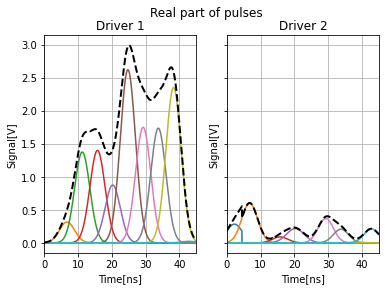

In [28]:
plot_signal(sig_envelopes, t_final)

#### Results of the optimisation
Plotting the dynamics with the same initial state:

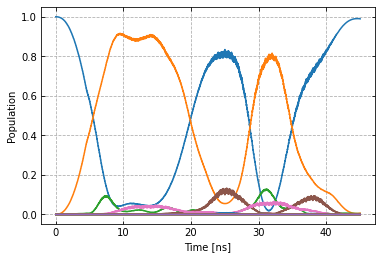

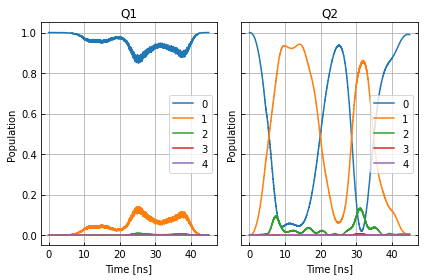

In [29]:
plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

Now we plot the dynamics for the control in the excited state.

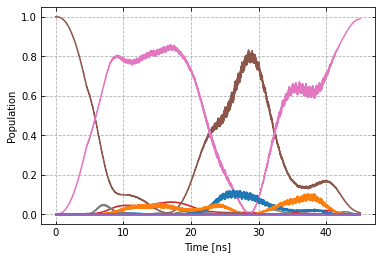

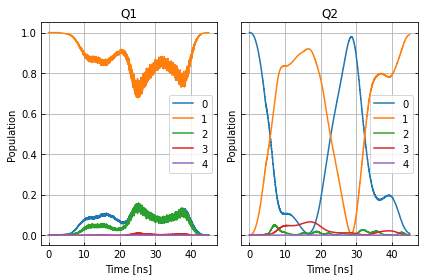

In [30]:
psi_init = [[0] * qubit_lvls ** 2]
psi_init[0][qubit_lvls] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

In [31]:
exp.write_config('two_qubits_entanglement_gauss_raw_var_sigma.hjson')